In [26]:
import pandas as pd
import numpy as np
import sklearn

import matplotlib 
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import average_precision_score

from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer

import time
from operator import itemgetter

import copy
from copy import deepcopy
print_mode = True

In [27]:
%run import_data


In [28]:
base = copy.deepcopy(merged_data)

colonnes_inutiles = ['num_veh','Num_Acc',
                                'locp',
                                'actp',
                                'etatp',
                                'catv',
                                'hrmn',
                                'mois',
                                'jour',
                                'catvopp',
                                'occutc',
                                'place']
merged_data = merged_data.drop(colonnes_inutiles,axis = 1)



In [35]:
target = merged_data.grav
merged_data = merged_data.drop('grav',axis = 1)
colnames = list(merged_data.columns)
colnames.remove('an_nais')
data_cat = merged_data[colnames]
data_cat = data_cat.astype(str)



X_cat = np.copy(data_cat) 
for col_id in range(len(X_cat[0])):
    unique_val, val_idx = np.unique(X_cat[:, col_id], return_inverse=True) 
    X_cat[:, col_id] = val_idx

imp_cat = Imputer(missing_values=np.nan, strategy='most_frequent') 
X_cat[:, range(5)] = imp_cat.fit_transform(X_cat[:, range(5)])


encodeur = OneHotEncoder()
encodeur.fit(X_cat)
X_cat = encodeur.transform(X_cat).toarray()

AttributeError: 'DataFrame' object has no attribute 'grav'

In [30]:
lol = pd.DataFrame(target)

In [31]:
colnames = list(merged_data.columns)
colnames.remove('an_nais')

In [ ]:
lol.shape

In [44]:
X_cat = pd.get_dummies(data_cat, columns = colnames)
X_cat = X_cat.astype(int)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_cat, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [47]:
def TP(theta,pred,result):
    count = 0
    i = 0
    for x in (result):
        if pred[i][1] > theta and x == 1:
            count += 1
        i += 1
    return count


def FP(theta,pred,result):
    count = 0
    i = 0
    for x in (result):
        if pred[i][1] >= theta and x == 0:
            count += 1
        i += 1
    return count


def TN(theta,pred,result):
    count = 0
    i = 0
    for x in (result):
        if pred[i][1] < theta and x == 0:
            count += 1
        i += 1
    return count


def FN(theta,pred,result):
    count = 0
    i = 0
    for x in (result):
        if pred[i][1] < theta and x == 1:
            count += 1
        i += 1
    return count


class ROC_curves:
    def __init__(self,
                 pred=merged_data,
                 res=target,
                 gran = 101):
        x = []
        y = []
        for j in range(0,gran):
            tn = TN(j/(gran-1),pred,res)
            neg = tn + FP(j/(gran-1),pred,res)
            tp = TP(j/(gran-1),pred,res)
            pos = tp + FN(j/(gran-1),pred,res)

            if neg == 0:
                x.append(0)
            else:
                x.append(tn / neg)
            if pos == 0:
                y.append(0)
            else:
                y.append(tp / pos)
      
        self.rocx = x
        self.rocy = y
    def plot_it(self):
        plt.plot(self.rocx,self.rocy)
        plt.show()

In [49]:
class Qualite:
    def __init__(self, 
                   _modele, 
                   _data=merged_data, 
                   _y=target, 
                   _y_pred=target,
                   _y_pred_proba=target,
                   _cv=10,
                   _print_mode=True):
        
        self.accuracy = sklearn.metrics.accuracy_score(_y, _y_pred)
        self.AUC = sklearn.metrics.roc_auc_score(_y, _y_pred)
        self.cross_validation = cross_val_score(_modele, _data, y=_y, cv=_cv)
        self.moyenne = np.mean(self.cross_validation)
        self.ecart_type = np.std(self.cross_validation)
        self.precision = average_precision_score(_y, _y_pred)
        
        self.roc = ROC_curves(pred=_y_pred_proba, res=_y)
        
        
        if _print_mode:
            self.roc.plot_it()

In [58]:
def algo_apprentissage(mod=GaussianNB(),
                           data=merged_data,
                           target=target_binaire,
                           print_mode=True,
                           cv=10):
    X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=42)
    result = dict()
    mod_fit = mod.fit(X_train, y_train)
    y_prediction_proba = mod_fit.predict_proba(X_test)
    y_prediction = mod_fit.predict(X_test)
    q_mod = Qualite(_modele=mod,
                 _data=X_test,
                 _y=y_test,
                 _y_pred=y_prediction,
                 _y_pred_proba=y_prediction_proba,
                 _print_mode=print_mode,
                 _cv=cv)
    
    result['y_prediction_proba'] = y_prediction_proba
    result['y_prediction'] = y_prediction
    result['q_mod'] = q_mod
    
    if print_mode:
        print('La précision est ' + str(q_mod.accuracy))
        print('')
        print('L\'AUC est ' + str(q_mod.AUC))
        print('')
        print('Le score moyen par ' + str(cv) + ' cross-validation est ' + str(q_mod.moyenne))
    
    return result

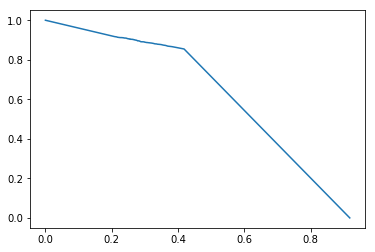

La précision est 0.530999383097

L'AUC est 0.584926585695

Le score moyen par 10 cross-validation est 0.536545304937


{'q_mod': <__main__.Qualite at 0x121fd4e80>,
 'y_prediction': array([1, 1, 1, ..., 0, 0, 1]),
 'y_prediction_proba': array([[  1.17422940e-51,   1.00000000e+00],
        [  8.68635910e-10,   9.99999999e-01],
        [  5.67179015e-10,   9.99999999e-01],
        ..., 
        [  9.90314647e-01,   9.68535275e-03],
        [  1.00000000e+00,   3.05520454e-14],
        [  9.33161795e-15,   1.00000000e+00]])}

In [59]:
target_binaire = target.replace([3,4],0)
target_binaire = target_binaire.replace(2,1)
algo_apprentissage(data=X_cat, target=target_binaire)

In [60]:
set(target_binaire)

{0, 1}

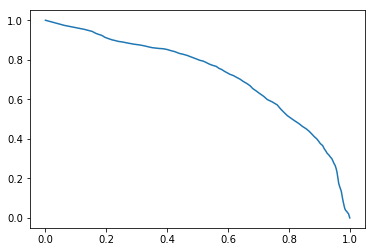

La précision est 0.670727945713

L'AUC est 0.670316778796

Le score moyen par 10 cross-validation est 0.637564490203


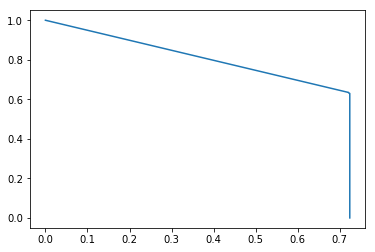

La précision est 0.684454040716

L'AUC est 0.676515310755

Le score moyen par 10 cross-validation est 0.677220982885


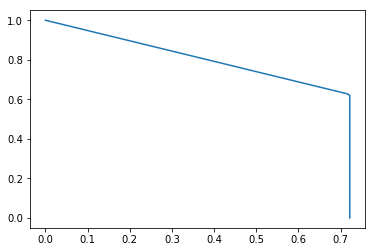

La précision est 0.679518815546

L'AUC est 0.670944476374

Le score moyen par 10 cross-validation est 0.682463854894


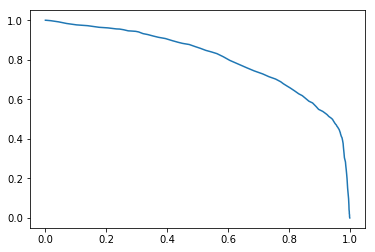

La précision est 0.75493522517

L'AUC est 0.729681359327

Le score moyen par 10 cross-validation est 0.75278313138


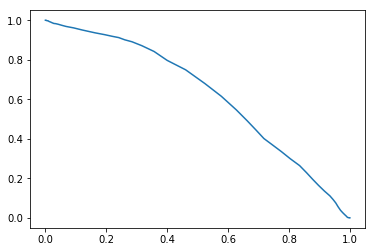

La précision est 0.597008019741

L'AUC est 0.543340285975

Le score moyen par 10 cross-validation est 0.586672556916


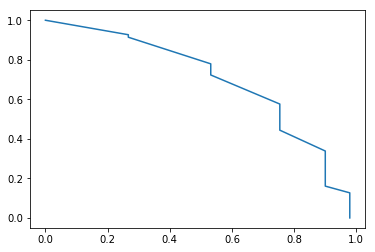

La précision est 0.680135718692

L'AUC est 0.66496863472

Le score moyen par 10 cross-validation est 0.655148066898


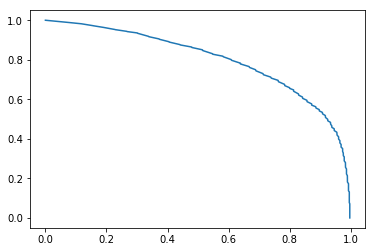

La précision est 0.745373226403

L'AUC est 0.728449090645

Le score moyen par 10 cross-validation est 0.73951746954


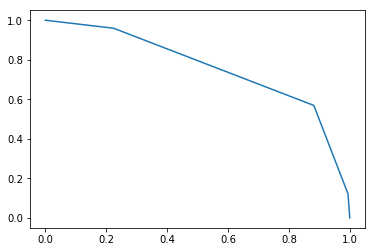

La précision est 0.752159161012

L'AUC est 0.72546734341

Le score moyen par 10 cross-validation est 0.746306878179


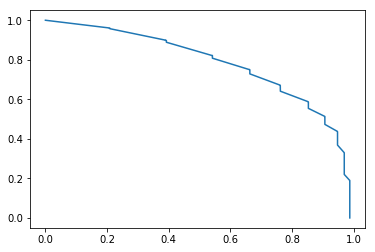

La précision est 0.742597162246

L'AUC est 0.720224983353

Le score moyen par 10 cross-validation est 0.745224018595


In [61]:
GNB = GaussianNB()
gnb = algo_apprentissage(GNB)

DTC = tree.DecisionTreeClassifier()
dtc = algo_apprentissage(DTC)

ID3 = tree.DecisionTreeClassifier(criterion="entropy")
id3 = algo_apprentissage(ID3)

decision_stump = GradientBoostingClassifier(n_estimators=100,
                                 learning_rate=1.0,
                                 max_depth=1,
                                 random_state=0)
ds = algo_apprentissage(decision_stump)

MLP = MLPClassifier(solver='lbfgs',
                    alpha=1,
                    hidden_layer_sizes=(20, 10))
mlp = algo_apprentissage(MLP)

KNN = KNeighborsClassifier()
knn = algo_apprentissage(KNN)

BC = BaggingClassifier(n_estimators=50)
bc = algo_apprentissage(BC)

ABC = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1.0,
                         algorithm='SAMME.R',
                         random_state=None)
abc = algo_apprentissage(ABC)

RFC = RandomForestClassifier(n_estimators=10,
                             criterion='gini',
                             max_depth=None,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0.0,
                             max_features='auto',
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             min_impurity_split=None,
                             bootstrap=True,
                             oob_score=False,
                             n_jobs=1,
                             random_state=None,
                             verbose=0,
                             warm_start=False,
                             class_weight=None)
rfc = algo_apprentissage(RFC)



In [63]:
colnames = ['Accuracy', 'AUC', 'Moyenne CV', 'Std CV', 'Temps']
algos = [KNN, DTC, ID3, BC, RFC, ABC, decision_stump]
indexs = ['KNN', 'DTC', 'id3', 'BC', 'RFC', 'ABC', 'DS']
clfs = dict()
for x in range(len(algos)):
    clfs[indexs[x]] = algos[x]
    
    
    
def final_table(mode=None,
                data=merged_data,
                target=target_binaire
                col=colnames,
                algos=algos,
                indexs=indexs):
    if mode is None:
        pass
    elif mode == 'normalized':
        scaler = StandardScaler()
        scaler.fit(data)
        data = scaler.transform(data)
    elif mode == 'min_max_ed':
        scaler = MinMaxScaler()
        scaler.fit(data)
        data = scaler.transform(data)
    elif mode == 'pca':
        data = pca_transform(data=data,
                                 normalized=True,
                                 print_mode=False)[1]


    result = []
    for alg in algos:
        t1 = time.time()
        res_algo = algo_apprentissage(alg, data=data, target=target,print_mode=False)
        t2 = time.time()
        delta_t = t2 - t1
        ajout = [res_algo['q_mod'].accuracy, res_algo['q_mod'].AUC, res_algo['q_mod'].moyenne, res_algo['q_mod'].ecart_type, delta_t]
        result.append(ajout)

    result = pd.DataFrame(result, columns=colnames, index=indexs)
    return result

modes = [None, 'normalized', 'min_max_ed', 'pca']

tables = dict()
for mode in modes:
    event = dict()
    tables[str(mode)] = final_table(mode=mode)

NameError: name 'pca_transform' is not defined

In [65]:
tables['None']

,Accuracy,AUC,Moyenne CV,Std CV,Temps
KNN,0.680136,0.664969,0.655148,0.014853,2.969997
DTC,0.678748,0.670286,0.677685,0.023620,1.733051
id3,0.681061,0.672479,0.679073,0.021611,1.757827
BC,0.746144,0.728566,0.739517,0.009180,13.753963
RFC,0.742289,0.720937,0.738129,0.014682,2.358127
ABC,0.752159,0.725467,0.746307,0.019707,3.782942
